In [2]:
#!pip install tensorflow==1.5

  Using cached https://files.pythonhosted.org/packages/04/79/a37d0b373757b4d283c674a64127bd8864d69f881c639b1ee5953e2d9301/tensorflow-1.5.0-cp36-cp36m-manylinux1_x86_64.whl
    100% |████████████████████████████████| 13.9MB 19kB/s  eta 0:00:01
You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [198]:
import os
import tensorflow as tf
os.chdir('/home/jovyan/work/data/conversation-structure-analysis/')
#!pip install --upgrade --user tensorflow
#!git clone https://github.com/tensorflow/tensorflow
#!cd tensorflow
#!git checkout

In [199]:
%run prerequisite_packages.ipynb
%run preprocessing_functions.ipynb
%run get_stopwords.ipynb
%run import_hand_labelled_data.ipynb

In [200]:
N = 20000
version = 1
df, train_turns, test_turns, test_labels, lengths = get_samples(version, size_n = N, document_level = 'turn', agent = 'all')


In [201]:
train_turns = df['message'].apply(lambda x: str(x).lower().strip())
train_turns = np.array(train_turns)


def fasttext_text_vect(model, train_turns):
    txt_path = """./data/df_with_embedding.txt"""
    with open(txt_path, 'w') as tmp:
        for _ in train_turns:
            tmp.write("%s\n" %_)    
    return
    #out_bytes = subprocess.check_output("""../fastText-0.1.0/fasttext print-sentence-vectors """ + model + """ < """ + txt_path, shell = True)     
    #return out_bytes.decode('utf-8')
fasttext_text_vect(None, train_turns)

In [202]:
embeddings = []
with open('/home/jovyan/work/data/conversation-structure-analysis/data/pure_sentence_embedding.txt', 'r') as vec_file:
    for l in vec_file.readlines():
        embeddings.append([float(_) for _ in l.split(" ")[-301:-1]])
        
#embeddings = np.array(embeddings) 


In [203]:
import scipy.sparse as sparse

arr = sparse.coo_matrix(embeddings, shape= np.array(embeddings).shape)
df['newcol'] = arr.toarray().tolist()

In [188]:
#df.to_csv('./data/df_with_embedding.csv', sep = ',')

In [204]:
df_all = pd.read_csv('./data/df_with_embedding.csv', sep = ',')
df = df_all[0:5000]

del df_all

df[0:2]

,Unnamed: 0,conv_uid,site_uid,message,agent,hand_label,newcol
0,0,ha-54621387,ha-4341,Bonjour si nous arrivons le dimanche matin ver...,visitor,"greeting, ask_for_product_information","[0.065945, 0.010356, 0.0035353, 0.023578, -0.0..."
1,1,ha-54621387,ha-4341,Bonjour ! La réception de l’hôtel est ouverte ...,operator,"greeting, send_product_information","[0.02754, 0.023644, 0.0081571, 0.0039379, -0.0..."


In [205]:
import ast


message_series = df['message']
agent_series = df['agent']

X_train = []
Y_train = []

count_v = count_a = 0


grp_lst = df.groupby('conv_uid').groups.items() 

for key, items in grp_lst:
    #print(key)
    X_temp = []
    Y_temp = []
    items = list(items)
    if df['agent'].iloc[items[0]]  == 'visitor':
        
        count_v +=1
        
    else:
        count_a +=1
    
    
    grp_agent = np.array([df['agent'].iloc[_] for _ in items])
    #print ('grp_agent {}'.format(grp_agent))
    visitor_turns_index = np.where(grp_agent == 'visitor')[0]
    #print ('items:{}'.format(items))
    
    #print ('visitor index {}'.format(visitor_turns_index))
    if len(visitor_turns_index)>0:
        old_first = first = items[visitor_turns_index[0]]
     #   print ('visitor first {}'.format(first))
    
        
        while(first <= items[-1]):
            
            #print ('first {} and last {}'.format(first, items[-1]))
        
            #msg = df['message'].iloc[first]
            vec = np.array([ast.literal_eval(df['newcol'].iloc[first])])
            j = 1
            while ((first+j) <= items[-1] and df['agent'].iloc[first+j] == df['agent'].iloc[old_first]):
                #msg = msg + df['message'].iloc[first+j]
                vec = vec + np.array([ast.literal_eval(df['newcol'].iloc[first+j])])
                j = j+1
            
            
            if df['agent'].iloc[old_first] == 'visitor' and old_first < items[-1]:
            
                X_temp.append((list(range(old_first, first+j)), vec*1.0/j))
                
            if df['agent'].iloc[old_first] == 'operator':
                
                Y_temp.append((list(range(old_first, first+j)), vec*1.0/j))
            
            old_first = first + j
            first = first + j
            
            #print ('now first is {}'.format(first))
    
    if len(X_temp)>0 and len(Y_temp)>0:
        X_train.append(X_temp)
        Y_train.append(Y_temp)

print('Number of conversations: {}'.format(len(X_train)))

Number of conversations: 509


length of x_train 509
longest turns: 29


(array([235., 152.,  64.,  29.,  12.,   9.,   6.,   0.,   1.,   1.]),
 array([ 1. ,  3.8,  6.6,  9.4, 12.2, 15. , 17.8, 20.6, 23.4, 26.2, 29. ]),
 <a list of 10 Patch objects>)

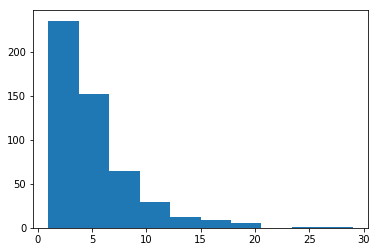

In [206]:
x_train = [[_[1] for _ in x_seq] for x_seq in X_train]
y_train = [[_[1] for _ in y_seq] for y_seq in Y_train]


print ('length of x_train {}'.format(len(x_train)))
#print ('length of Y_train {}'.format(len(Y_train)))

lengths = [len(_) for _ in x_train]
maxlen = max(lengths)
print ('longest turns: {}'.format(maxlen))

import matplotlib.pyplot as plt

plt.hist(lengths)



In [207]:
from sklearn.feature_extraction.text import CountVectorizer

maxlen = 20

def padding_turns(sequence, maxlen):
    if len(sequence) < maxlen:
        sequence = sequence + list(np.tile(np.zeros(shape = sequence[0].shape), ((maxlen - len(sequence)), 1,1))) ## [['PAD']]*(maxlen - len(sequence))
    elif len(sequence) > maxlen:
        sequence = sequence[0:maxlen]
    else:
        sequence = sequence
    
    return sequence


x_train = np.array([padding_turns(x_train[i], maxlen) for i in range(len(x_train))])

y_train = np.array([padding_turns(y_train[i], maxlen) for i in range(len(y_train))])

#print(y_train[0])

In [48]:
"""
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=100,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(data_samples)

tf

""" 

<3x6 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

In [208]:
from __future__ import print_function
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional


In [210]:
max_features = 300 
# cut texts after this number of words
# (among top max_features most common words)
batch_size = 32
x_train = x_train.reshape((len(x_train), maxlen, 300))
y_train = y_train.reshape((len(y_train), maxlen, 300))
print ('shape of x_train:{}'.format(x_train.shape))
print ('shape of y_train:{}'.format(y_train.shape))

shape of x_train:(509, 20, 300)
shape of y_train:(509, 20, 300)


In [211]:
model = Sequential()
model.add(Embedding(input_dim = max_features, output_dim = 128, input_length = maxlen))
model.add(Bidirectional(LSTM(128, return_sequences= True, input_shape = (20, 300))))
model.add(Dropout(0.5))
model.add(Dense(max_features, activation='relu'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'cosine_proximity', metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size= batch_size,
          epochs = 4)



### next: meaning of embedding, how to yield hidden state of each cell of bidirectional lstm.

Train...


ValueError: Error when checking input: expected embedding_11_input to have 2 dimensions, but got array with shape (509, 20, 300)